Question 1: Training and Evaluating a Variational Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2025-07-12 15:23:21.374920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 15:23:21.374985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 15:23:21.376033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 15:23:21.383380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-12 15:23:22.464240: W tensorflow/compiler/tf2

# 1. Load and Preprocess the Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


# Normalize and reshape the data

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

2025-07-12 15:23:24.824983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-12 15:23:24.869366: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-12 15:23:24.870816: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


# 2. Define the VAE Architecture

In [4]:
latent_dim = 2

class CVAE(tf.keras.Model):
  """Convolutional Variational Autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


# 3. Define the Loss Function and Optimizer

In [5]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# 4. Train the Model

In [6]:
epochs = 10
model = CVAE(latent_dim)

for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}'.format(epoch, elbo))

2025-07-12 15:23:25.159324: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch: 1, Test set ELBO: -223.50624084472656
Epoch: 2, Test set ELBO: -214.2041778564453
Epoch: 3, Test set ELBO: -208.36512756347656
Epoch: 4, Test set ELBO: -203.6176300048828
Epoch: 5, Test set ELBO: -200.59957885742188
Epoch: 6, Test set ELBO: -198.2369384765625
Epoch: 7, Test set ELBO: -196.69845581054688
Epoch: 8, Test set ELBO: -195.67709350585938
Epoch: 9, Test set ELBO: -194.6249237060547
Epoch: 10, Test set ELBO: -193.4088897705078


# Question 2: Generating Images from Custom Noise Vectors

# 5. Generate Five Images from Custom Noise

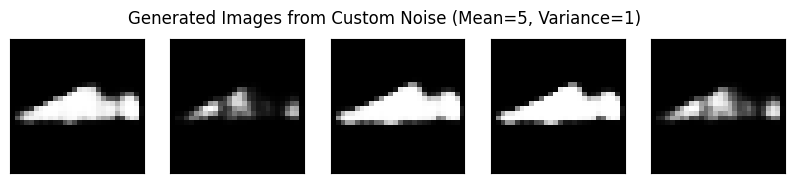


Showing original vs. reconstructed images from the test set:


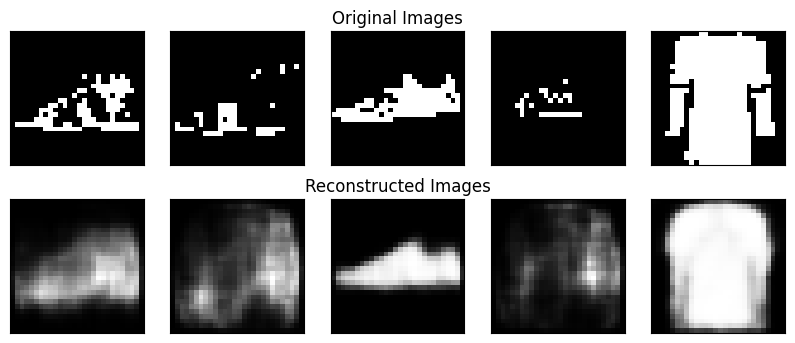

In [7]:
num_images_to_generate = 5
mean_of_noise = 5.0
variance_of_noise = 1.0  # Standard deviation is the square root of variance

# Create noise vectors from a normal distribution with a specified mean and variance
noise_vectors = tf.random.normal(
    shape=[num_images_to_generate, latent_dim],
    mean=mean_of_noise,
    stddev=tf.sqrt(variance_of_noise)
)

# Generate images by passing the noise vectors through the decoder
generated_images = model.sample(noise_vectors)

# Display the generated images
plt.figure(figsize=(10, 2))
for i in range(num_images_to_generate):
    ax = plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Generated Images from Custom Noise (Mean=5, Variance=1)')
plt.show()

# To demonstrate reconstruction, we can also pass some test images through the VAE
def plot_reconstructions(model, test_dataset, num_to_show=5):
    plt.figure(figsize=(10, 4))
    test_batch = next(iter(test_dataset))
    test_images = test_batch[:num_to_show]

    mean, logvar = model.encode(test_images)
    z = model.reparameterize(mean, logvar)
    reconstructions = model.sample(z)

    for i in range(num_to_show):
        # Plot original
        ax = plt.subplot(2, num_to_show, i + 1)
        plt.imshow(test_images[i, :, :, 0], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_to_show // 2:
            ax.set_title("Original Images")

        # Plot reconstruction
        ax = plt.subplot(2, num_to_show, i + 1 + num_to_show)
        plt.imshow(reconstructions[i, :, :, 0], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_to_show // 2:
            ax.set_title("Reconstructed Images")
    plt.show()

print("\nShowing original vs. reconstructed images from the test set:")
plot_reconstructions(model, test_dataset)